In [1]:
import sinter
import pymatching
import numpy as np
from typing import *
import math
import csv
from Surface import surface_data 
from generate_circuit import generate_circuit

# Generate the data
def my_circuit(n, noise, noise2):
    data = surface_data(n, 2 * n, n, 3, display_svg=False)
    circuit = generate_circuit(data, noise, noise2, n)
    return circuit

base = 500
pr = np.arange(0.001, 0.03, 0.001)
#print(pr)

# Iterate over different n values
n_values = [3, 5, 7]
results = []

for n in n_values:
    CAT_code_tasks = [
        sinter.Task(
            circuit=my_circuit(n, p, noise2=0.1),
            json_metadata={'p': p},
        )
        for p in pr
    ]

    # Sampling
    collected_baconshor_code_stats: List[sinter.TaskStats] = sinter.collect(
        num_workers=9,
        tasks=CAT_code_tasks,
        decoders=['pymatching'],
        max_shots=base * 200,
        max_errors=base,
        print_progress=True,
    )

    # Get data (physical error rate=p, logical error rate=l)
    for stats in collected_baconshor_code_stats:
        p = stats.json_metadata['p']
        l = stats.errors / stats.shots if stats.errors != 0 else 0
        results.append([n, p, l])

# Save results to a CSV file
with open('results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['n', 'physical_error_rate', 'logical_error_rate'])
    writer.writerows(results)


Starting 9 workers...
29 cases left:
    pymatching processes=3  ~core_mins_left=1       shots_left=62800    errors_left=489     {p=0.001}
    pymatching processes=3  ~core_mins_left=1       shots_left=56800    errors_left=459     {p=0.002}
    pymatching processes=3  ~core_mins_left=1       shots_left=95500    errors_left=485     {p=0.003}
    pymatching processes=0  ~core_mins_left=4       shots_left=99900    errors_left=499     {p=0.004}
    pymatching processes=0  ~core_mins_left=4       shots_left=99900    errors_left=499     {p=0.005}
    pymatching processes=0  ~core_mins_left=8       shots_left=99900    errors_left=500     {p=0.006}
    pymatching processes=0  ~core_mins_left=4       shots_left=99900    errors_left=499     {p=0.007}
    pymatching processes=0  ~core_mins_left=8       shots_left=99900    errors_left=500     {p=0.008}
    pymatching processes=0  ~core_mins_left=1       shots_left=99900    errors_left=496     {p=0.009000000000000001}
Done collecting
Starting 9 wor

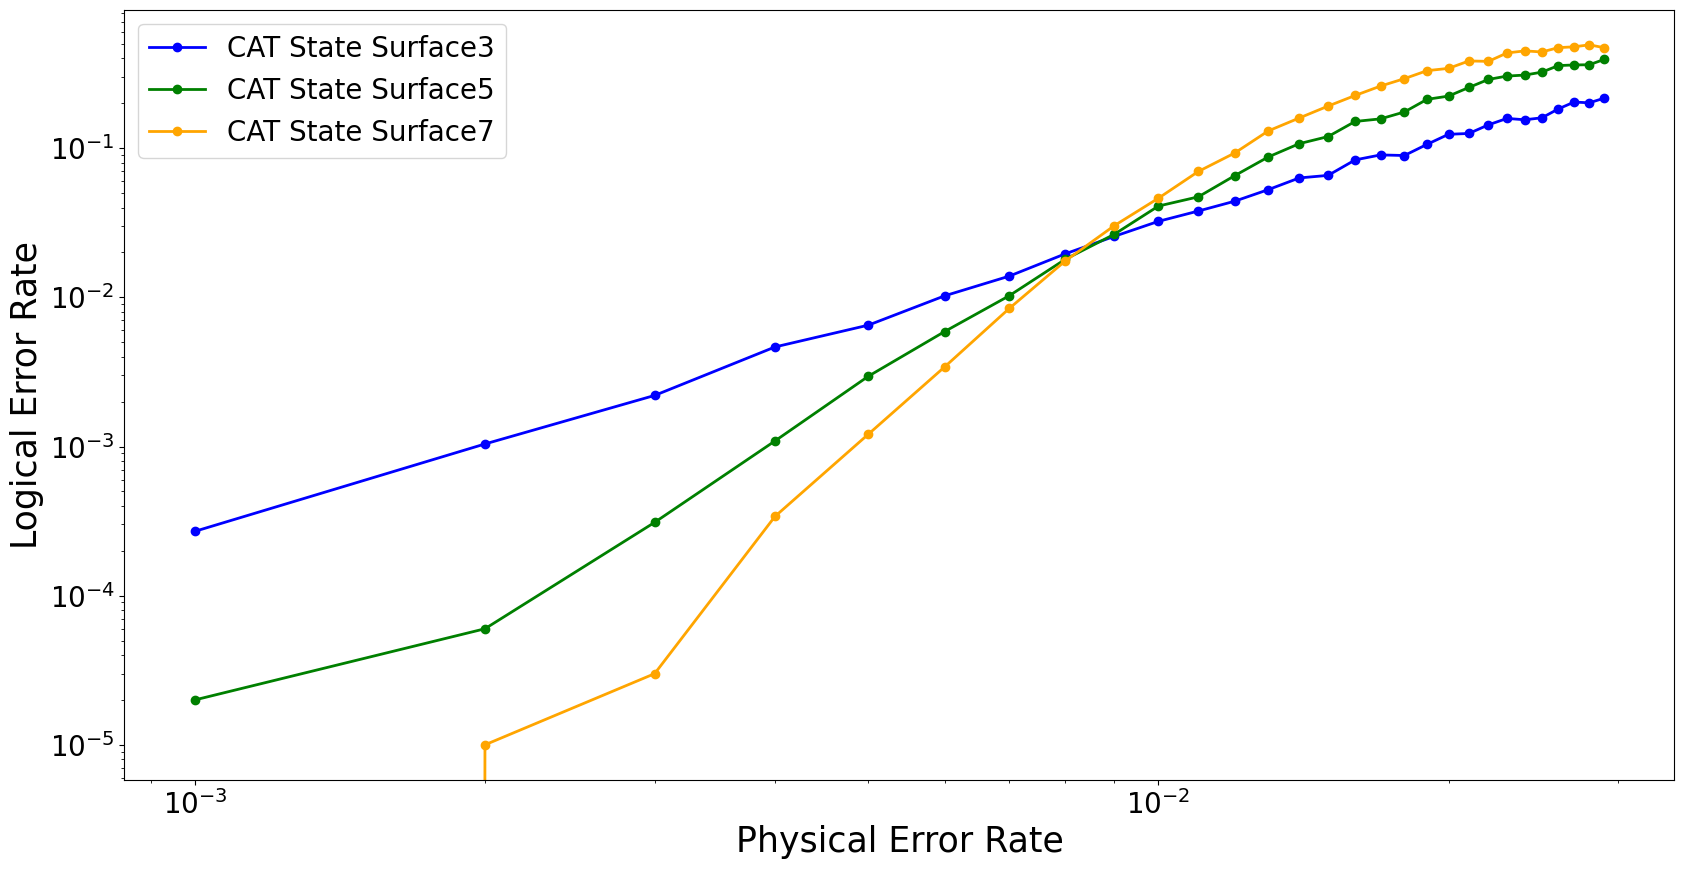

In [2]:
import matplotlib.pyplot as plt
import csv

def load_results_from_csv(filepath: str):
    results = []
    with open(filepath, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            n = int(row['n'])
            p = float(row['physical_error_rate'])
            l = float(row['logical_error_rate'])
            results.append([n, p, l])
    return results


import matplotlib.pyplot as plt
from collections import defaultdict

def plot_results(results):
    # Organize results into a dictionary
    data = defaultdict(lambda: {'plist': [], 'llist': []})
    
    for result in results:
        n, p, l = result
        data[n]['plist'].append(p)
        data[n]['llist'].append(l)

    plt.figure(figsize=(20, 10))

    # Generate colors dynamically if needed
    colors = ['blue', 'green', 'orange']
    n_values = list(data.keys())

    if len(colors) < len(n_values):
        import itertools
        colors = list(itertools.cycle(colors))

    # Generate labels dynamically
    labels = [f'CAT State Surface{n}' for n in n_values]

    for idx, n in enumerate(n_values):
        plist = data[n]['plist']
        llist = data[n]['llist']

        if len(plist) == 0 or len(llist) == 0:
            print(f'Warning: No data for n = {n}')
            continue

        # Combine plist and llist, sort by plist, and unzip
        sorted_data = sorted(zip(plist, llist))
        sorted_plist, sorted_llist = zip(*sorted_data)

        # Print data points to verify
        #print(f'n = {n}')
        #for p, l in zip(sorted_plist, sorted_llist):
            #print(f'Physical Error Rate: {p}, Logical Error Rate: {l}')

        # Plot data points and lines
        plt.loglog(sorted_plist, sorted_llist, marker='o', linestyle='-', linewidth=2, color=colors[idx], label=labels[idx])

    # Add labels to plot
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Physical Error Rate", fontsize=25)
    plt.ylabel("Logical Error Rate", fontsize=25)
    legend = plt.legend(title='', fontsize=20)
    plt.savefig('CAT_regular.pdf')
    plt.show()


#plot_results(results)

# Or load from CSV and plot
data_from_csv = load_results_from_csv('results.csv')
plot_results(data_from_csv)
